<a href="https://colab.research.google.com/github/RogMaverick18/Speech-Processing-Lab-assignments/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 27.5 MB/s eta 0:00:00


2026-01-28 07:01:36.532309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769583696.781607      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769583696.857500      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769583697.450156      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769583697.450208      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769583697.450211      55 computation_placer.cc:177] computation placer alr

Loading model: facebook/wav2vec2-lv-60-espeak-cv-ft...


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2PhonemeCTCTokenizer'. 
The class this function is called from is 'Wav2Vec2CTCTokenizer'.


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Processing file: LJ050-0274.wav


model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]


Total Phonemes Detected: 44
Phoneme Sequence: m eɪ d s ɜː t ə n ɹ ɛ k ə m ə n d eɪ ʃ ə n z w ɪ tʃ ɪ t b ᵻ l iː v z w ʊ d ɪ f ɐ d ɑː p t ᵻ d


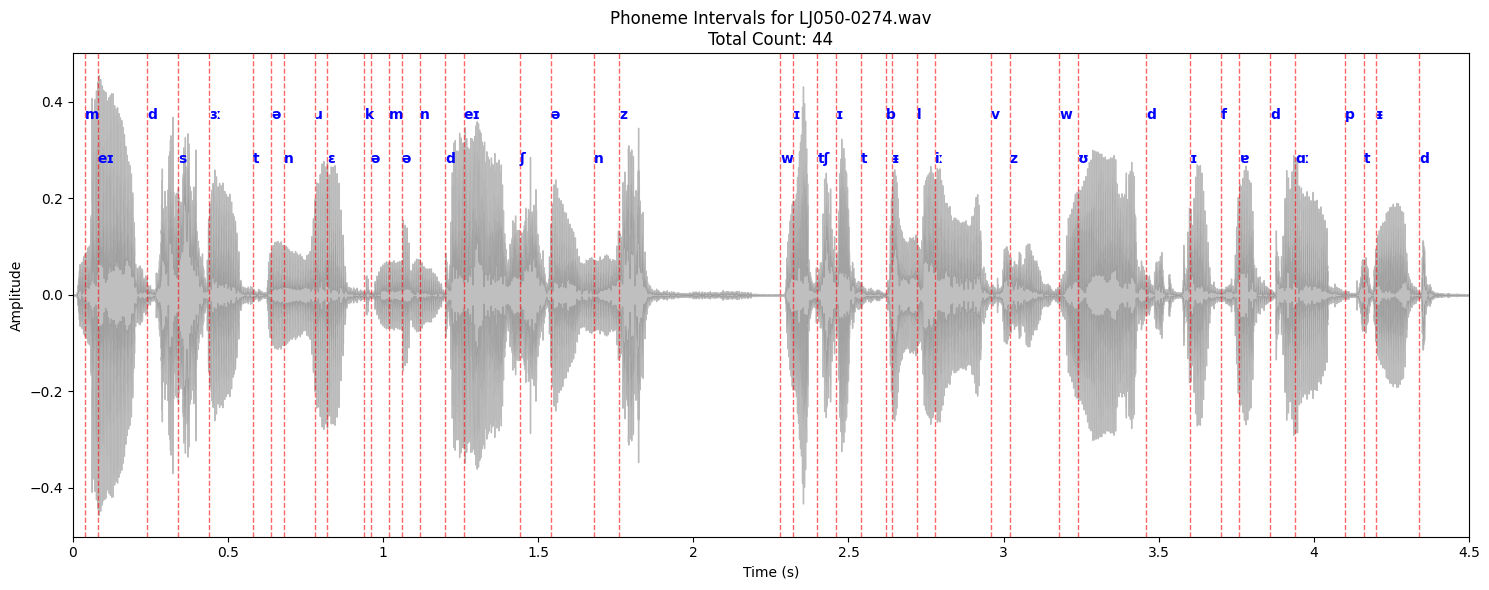


Example Extraction: Phoneme 'ɜː'
Interval: 0.440s to 0.580s
Nature of Source: Voiced (Source: Vocal Cord Vibration)
Explanation: This is likely a vowel or voiced consonant produced by periodic vocal cord vibration.


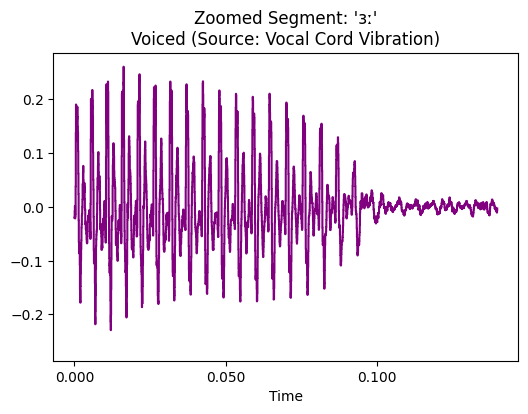

Saved extracted segment to: extracted_phoneme_ɜː.wav


In [ ]:
# ==========================================
# 1. INSTALLATION & IMPORTS
# ==========================================
!pip install torch torchaudio librosa transformers matplotlib phonemizer

import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor
import os

# ==========================================
# 2. SETUP & CONFIGURATION
# ==========================================
# Use a phoneme-specific model (IPA/espeak based)
MODEL_NAME = "facebook/wav2vec2-lv-60-espeak-cv-ft"
print(f"Loading model: {MODEL_NAME}...")

# Adjusted initialization to avoid TypeError in newer transformers versions
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(MODEL_NAME)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

model = Wav2Vec2ForCTC.from_pretrained(MODEL_NAME)

# Path to your file (Update to correct Kaggle input path)
# Only using ONE file as requested
FILE_PATH = "/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ050-0274.wav"

# ==========================================
# 3. PROCESSING & VISUALIZATION
# ==========================================

if os.path.exists(FILE_PATH):
    # --- A. Load and Preprocess ---
    print(f"Processing file: {os.path.basename(FILE_PATH)}")
    # Load audio at 16kHz (required for Wav2Vec2)
    speech_array, sr = librosa.load(FILE_PATH, sr=16000)

    # --- B. Model Inference ---
    # Tokenize
    input_values = processor(speech_array, return_tensors="pt", sampling_rate=16000).input_values

    # Forward pass
    with torch.no_grad():
        logits = model(input_values).logits

    # --- C. Extract Phonemes & Time Intervals ---
    # Get predicted IDs
    predicted_ids = torch.argmax(logits, dim=-1)

    # Decode to phonemes (gives the string of phonemes)
    transcription = processor.batch_decode(predicted_ids)

    # To get TIME INTERVALS, we need to look at the non-blank tokens manually
    # Wav2Vec2 outputs a frame roughly every 20ms (0.02s)
    # Formula: time = frame_index * (model_stride / sample_rate)
    # The stride for this model is typically 320 samples (320/16000 = 0.02s)
    time_offset = model.config.inputs_to_logits_ratio / processor.feature_extractor.sampling_rate

    # Filter out "pad" or "blank" tokens (CTC blank token is usually ID 0)
    # We store (token_id, time_start)
    phoneme_events = []

    # predicted_ids[0] contains the sequence of token IDs for every frame
    raw_tokens = predicted_ids[0].tolist()

    # Simple collapsing of repeated tokens (standard CTC decoding logic)
    # and ignoring blanks (ID 0 or processor.tokenizer.pad_token_id)
    previous_token = None

    for i, token_id in enumerate(raw_tokens):
        # 0 is usually the CTC blank token
        if token_id != 0 and token_id != processor.tokenizer.pad_token_id:
            # Only add if it's different from the previous one (merge repeats)
            if token_id != previous_token:
                phoneme_char = processor.decode(token_id)
                time_point = i * time_offset
                phoneme_events.append({
                    "phoneme": phoneme_char,
                    "time": time_point,
                    "frame": i
                })
            previous_token = token_id
        else:
            previous_token = token_id

    # --- D. Print Results ---
    num_phonemes = len(phoneme_events)
    print(f"\nTotal Phonemes Detected: {num_phonemes}")
    print(f"Phoneme Sequence: {' '.join([p['phoneme'] for p in phoneme_events])}")

    # --- E. Visualization ---
    plt.figure(figsize=(15, 6))

    # Plot Waveform
    librosa.display.waveshow(speech_array, sr=sr, alpha=0.5, color='gray')

    # Overlay Phoneme Intervals
    # We plot a vertical line at the start of each new phoneme
    for i, event in enumerate(phoneme_events):
        t = event["time"]
        p = event["phoneme"]

        # Draw vertical line
        plt.axvline(x=t, color='r', linestyle='--', alpha=0.6, linewidth=1)

        # Label the phoneme. We alternate height to avoid overlapping text
        y_pos = 0.8 if i % 2 == 0 else 0.6
        # Transform y_pos to data coordinates roughly
        plt.text(t, np.max(speech_array) * y_pos, p, color='blue', fontsize=10, fontweight='bold')

    plt.title(f"Phoneme Intervals for {os.path.basename(FILE_PATH)}\nTotal Count: {num_phonemes}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.xlim(0, len(speech_array)/sr) # Set x-axis limit to audio length
    plt.tight_layout()
    plt.show()

    # --- F. Extract a Specific Segment (e.g., the 5th phoneme) ---
    if num_phonemes >= 5:
        target_idx = 4 # 5th phoneme
        p_data = phoneme_events[target_idx]

        # Estimate end time (start of next phoneme, or +0.05s if it's the last one)
        start_t = p_data['time']
        if target_idx + 1 < num_phonemes:
            end_t = phoneme_events[target_idx + 1]['time']
        else:
            end_t = start_t + 0.1

        print(f"\nExample Extraction: Phoneme '{p_data['phoneme']}'")
        print(f"Interval: {start_t:.3f}s to {end_t:.3f}s")

        # --- Inference Logic ---
        # Identify nature of source (Voiced vs Unvoiced)
        # Common Voiceless IPA symbols: p, t, k, f, θ, s, ʃ, h...
        voiceless_epa = {'p', 't', 'k', 'f', 'θ', 's', 'ʃ', 'h', 'ʧ', 'ts', 't∫'}
        if p_data['phoneme'] in voiceless_epa:
            nature = "Unvoiced (Source: Turbulent Noise)"
            print(f"Nature of Source: {nature}")
            print("Explanation: This is likely a fricative or stop consonant produced by identifying airflow constriction.")
        else:
            nature = "Voiced (Source: Vocal Cord Vibration)"
            print(f"Nature of Source: {nature}")
            print("Explanation: This is likely a vowel or voiced consonant produced by periodic vocal cord vibration.")

        # Slicing
        start_sample = int(start_t * sr)
        end_sample = int(end_t * sr)
        segment = speech_array[start_sample:end_sample]

        # Plot Segment
        plt.figure(figsize=(6, 4))
        librosa.display.waveshow(segment, sr=sr, color='purple')
        plt.title(f"Zoomed Segment: '{p_data['phoneme']}'\n{nature}")
        plt.show()

        # Save the extracted phoneme to a file
        import soundfile as sf
        output_filename = f"extracted_phoneme_{p_data['phoneme']}.wav"
        sf.write(output_filename, segment, sr)
        print(f"Saved extracted segment to: {output_filename}")

else:
    print("Error: File not found. Please check the FILE_PATH variable.")